<a href="https://colab.research.google.com/github/Mbonea-Mjema/Sudoku-Solver-Machine-vision/blob/master/sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#To do list
# - install the required modules
# - find the grid
# - get the grid values
# - put the values in a matrix of somesort
# - solve the sudoku puzzle
# - write the answers you got




# Install the required modules

In [0]:
!pip3 install mnist
!sudo apt-get install aria2c

## **Download the required files**

In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg/1200px-Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg.png -O sudoku.png
#!wget https://thousandislandslife.com/content/images/2019/06/Puzzle-54.JPG -O sudoku.jpg
!wget -qO- http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz | tar zxvf -


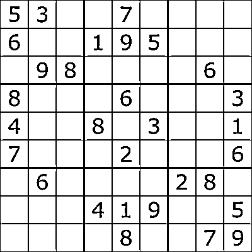

In [44]:
import PIL
import cv2
from google.colab.patches import cv2_imshow
from numpy import array
from PIL import Image
from PIL import ImageFilter
import numpy as np

pic_size =400

image=Image.open("./sudoku.png",)
image = image.convert("L")

width,height  = image.size # get the image dimensions
aspect_ratio = height/width # get the image aspect ratio
base_size = pic_size,pic_size*aspect_ratio # get the base size we want

image.thumbnail(base_size) 
image.save("./sudoku_small.png")


img = cv2.imread('./sudoku_small.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gaus_blur = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT) 

thresh = cv2.adaptiveThreshold(gaus_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, 11, 5)   

edges = cv2.Canny(thresh,50,150,apertureSize = 3)
lines = cv2.HoughLinesP(edges,1,np.pi/180,20,100)
for line in lines:
  x1,y1,x2,y2 = line[0]
  cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)


small =cv2.resize(thresh,(252,252))
cv2_imshow(small) 
#cv2.imwrite('houghlines3.jpg',image_array)


In [54]:
five =small[:28, :28]
cv2_imshow(five)

In [0]:
img

# **Deep Neural Networks Part**

In [42]:
#create our sampling data and labels
import os
import cv2
from numpy import zeros
import numpy as np
def folder_number(num):
  return str(num).zfill(3)
folders="/content/English/Fnt/Sample{}"
count =0
all_images=zeros((1016*10,28,28),dtype='uint8')
all_labels = zeros((1016*10,),dtype='uint8')
for i in range(1,11,1):
  current_dir = folders.format(folder_number(i))
  for image in os.listdir(current_dir):
    image = os.path.join(current_dir,image)
    image_array=cv2.imread(image)
    gray = cv2.cvtColor(image_array,cv2.COLOR_BGR2GRAY)
    try:
      small=cv2.resize(gray,(28,28))
      all_images[count]=small
      all_labels[count]=i-1
      count+=1
    except Exception as e:
      print(image,e)

#randomize the two numpy arrays the same way
random_order = np.arange(all_images.shape[0])
np.random.shuffle(random_order)
all_images=all_images[random_order]
all_labels=all_labels[random_order]

cv2_imshow(all_images[0])
print(all_labels[0])

train = int(all_images.shape[0]*.8)
train_images = all_images[:train]
train_labels =all_labels[:train]

test_images = all_images[train+1:]
test_labels =all_labels[train+1:]


# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

# Build the model.
model = Sequential([
  Dense(64, activation='relu', input_shape=(784,)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=5,
  batch_size=32,
)




8
Epoch 1/5
8128/8128 [==============================] - 1s 88us/step - loss: 0.5000 - acc: 0.8610
Epoch 2/5
8128/8128 [==============================] - 0s 61us/step - loss: 0.1603 - acc: 0.9524
Epoch 3/5
8128/8128 [==============================] - 0s 61us/step - loss: 0.1113 - acc: 0.9663
Epoch 4/5
8128/8128 [==============================] - 0s 61us/step - loss: 0.0965 - acc: 0.9691
Epoch 5/5
8128/8128 [==============================] - 0s 60us/step - loss: 0.0839 - acc: 0.9748


In [41]:
train

8128.0

In [0]:
import numpy as np
import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

# Build the model.
model = Sequential([
  Dense(64, activation='relu', input_shape=(784,)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=5,
  batch_size=32,
)

In [53]:
model.evaluate(
  test_images,
  to_categorical(test_labels)
)

model.save_weights('model.h5')

# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]






2031/2031 [==============================] - 0s 49us/step
[4 0 8 9 9]
[4 0 8 9 9]


In [55]:
five = (five / 255) - 0.5
five= five.reshape((-1, 784))
predictions=model.predict(five)
predictions
print(np.argmax(predictions, axis=1))

[5]
